<a href="https://colab.research.google.com/github/Himagination/GANs/blob/main/SN_DCGAN_Handwritten_Digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spectrally Normalized Generative Adversarial Networks(SN-GAN)

- Spectral Normalization is weight normalization technique to stabilize the training of the discriminator.
- SN-GAN normalizes the weight matrices in the discriminator by their corresponding `spectral norm`, which helps control the Lipschitz constant of the discriminator.
- Spectral Normalization helps improve stability and avoid vanishing gradient problems, such as mode collapse.
- Spectral Norm of a matrix is the matrix's largest singular value, which can be obtained via Singular Value Decomposition.

# DCGAN with Spectral Normalization

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(0)

## Utility Function

In [3]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
  image_tensor = (image_tensor + 1) / 2
  image_unflat = image_tensor.detach().cpu()
  image_grid = make_grid(image_unflat[:num_images], nrow=5)
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.show()

## DCGAN Generator

As Spectral Normalization is only applied to the matrices in the discriminator, the generator implementation is the same as the original.

In [21]:
class Generator(nn.Module):
  def __init__(self, 
               z_dim=10, 
               im_chan=1, 
               hidden_dim=10):
    super(Generator, self).__init__()
    self.z_dim = z_dim
    self.gen = nn.Sequential(
        self.make_gen_block(z_dim, hidden_dim*4), 
        self.make_gen_block(hidden_dim*4, hidden_dim*2, kernel_size=4, stride=1), 
        self.make_gen_block(hidden_dim*2, hidden_dim), 
        self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True)
    )

  def make_gen_block(self, 
                     input_channels, 
                     output_channels, 
                     kernel_size=3, 
                     stride=2, 
                     final_layer=False):
    
    if not final_layer:
      return nn.Sequential(
          nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride), 
          nn.BatchNorm2d(output_channels), 
          nn.ReLU(inplace=True),
      )
    else:
      return nn.Sequential(
          nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride), 
          nn.Tanh()
      )

  def unsqueeze_noise(self, noise):
    return noise.view(len(noise), self.z_dim, 1, 1)

  def forward(self, noise):
    x = self.unsqueeze_noise(noise)
    return self.gen(x)

def get_noise(n_samples, z_dim, device="cpu"):
  return torch.randn(n_samples, z_dim, device=device)


## DCGAN Discriminator

For the discriminator, for each Convolution, $W_{SN}$ is calculated instead of Weight W. It requires extra parameters ũ and ṽ. $\overline{W}_{SN} := \tilde{u}^\top W\tilde{v}$.

- `nn.utils.spectral_norm` can be used for the same.

In [22]:
class Discriminator(nn.Module):
  def __init__(self, im_chan=1, hidden_dim=16):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        self.make_disc_block(im_chan, hidden_dim), 
        self.make_disc_block(hidden_dim, hidden_dim*2), 
        self.make_disc_block(hidden_dim*2, 1, final_layer=True)
    )

  def make_disc_block(self, 
                      input_channels, 
                      output_channels, 
                      kernel_size=4, 
                      stride=2, 
                      final_layer=False):
    if not final_layer:
      return nn.Sequential(
          nn.utils.spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride)),
          nn.BatchNorm2d(output_channels), 
          nn.LeakyReLU(0.2, inplace=True),
      )
    else:
      return nn.Sequential(
          nn.utils.spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride))
      )

  def forward(self, image):
    disc_pred = self.disc(image)
    return disc_pred.view(len(disc_pred), -1)

## Training

In [23]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 50
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, ), (0.5, ))
                                ])
dataloader = DataLoader(
    MNIST('.', download=True, transform=transform), 
    batch_size=batch_size, 
    shuffle=True
)

In [24]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m, nn.BatchNorm2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 0.7061451740264888 Discriminator loss: 0.6597138426303863


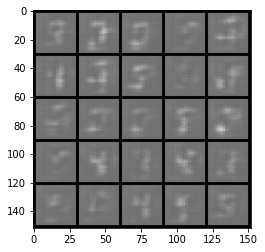

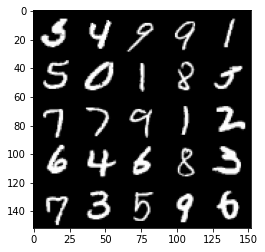

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 0.910471586942673 Discriminator loss: 0.5372905541062355


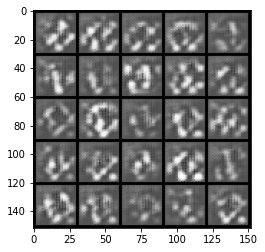

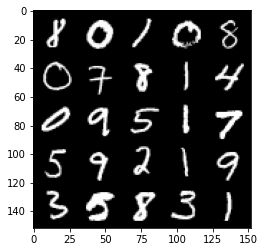

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 1.226376521706582 Discriminator loss: 0.39161214977502834


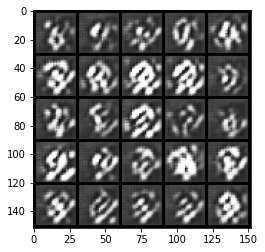

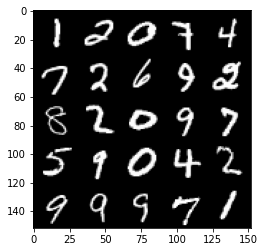

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.149876385509967 Discriminator loss: 0.4278329187035561


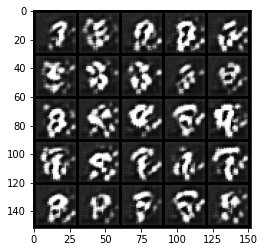

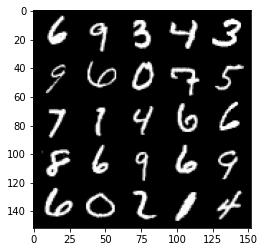

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 1.0232129129171363 Discriminator loss: 0.48554494738578824


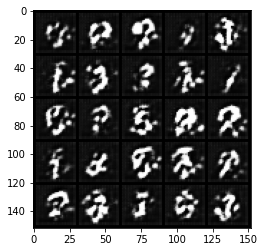

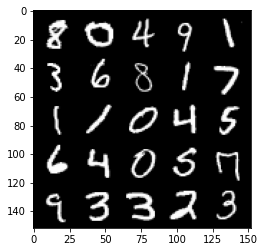

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 0.9190047640800483 Discriminator loss: 0.5422997278571134


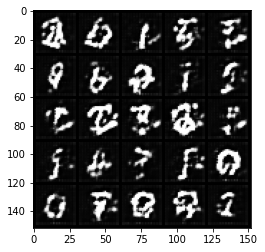

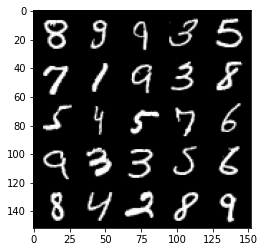

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 0.8716949465274818 Discriminator loss: 0.5705971676111224


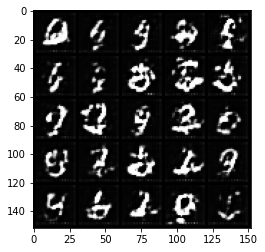

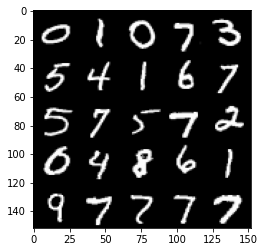

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 0.8513519513607024 Discriminator loss: 0.5818677830696104


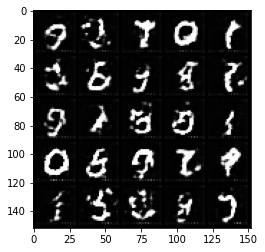

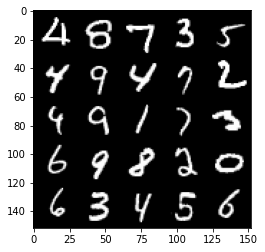

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 0.8391790865659713 Discriminator loss: 0.5887537463903428


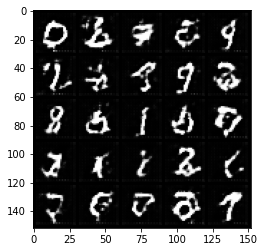

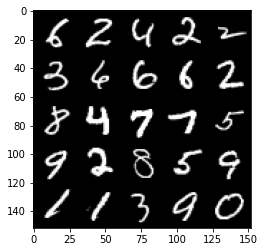

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 0.8247095042467121 Discriminator loss: 0.5992930167913434


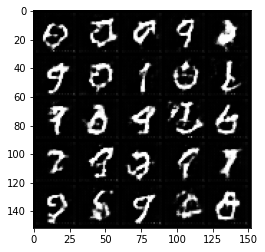

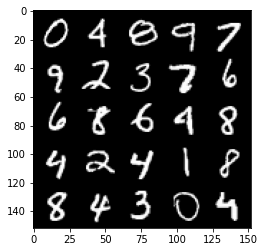

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 0.8189214388132097 Discriminator loss: 0.60595645236969


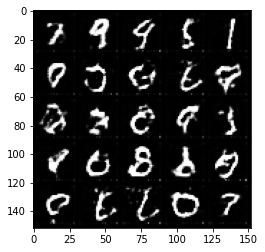

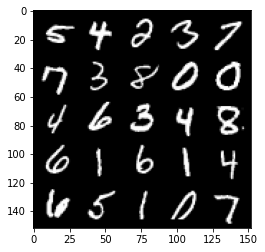

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 0.8124867027997973 Discriminator loss: 0.6098987965583809


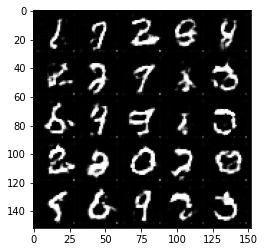

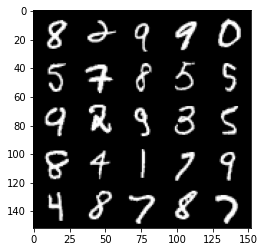

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 0.8128854466676717 Discriminator loss: 0.6095611404180528


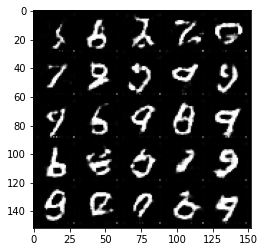

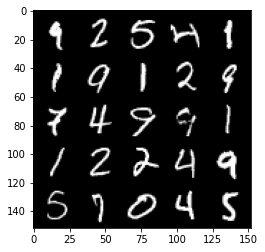

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 0.8132100448608397 Discriminator loss: 0.6102918175458908


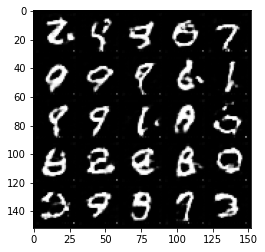

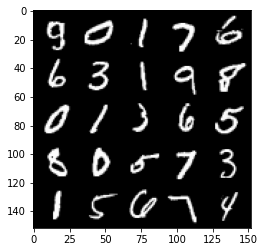

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 0.8180812828540803 Discriminator loss: 0.6104504545927046


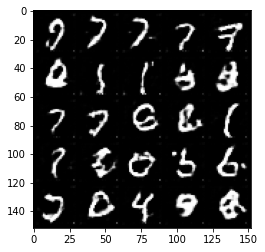

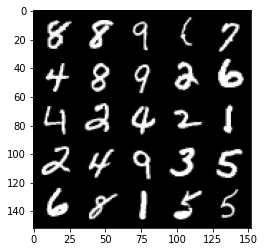

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 0.8190671319961549 Discriminator loss: 0.6077360415458679


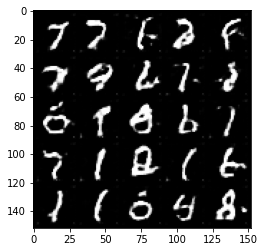

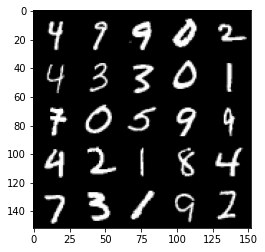

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 0.8203674352169045 Discriminator loss: 0.6077890591621398


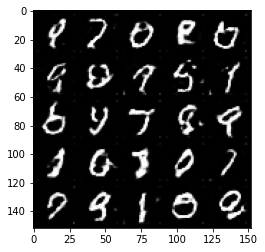

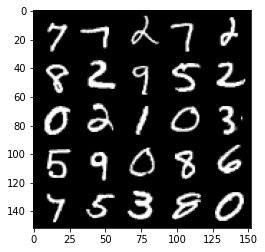

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 0.8257467693090444 Discriminator loss: 0.6074551222324369


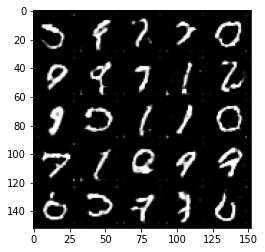

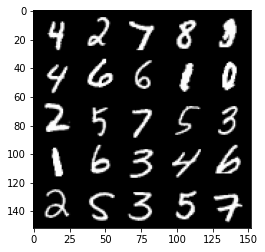

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 0.824663029015065 Discriminator loss: 0.6082238157987592


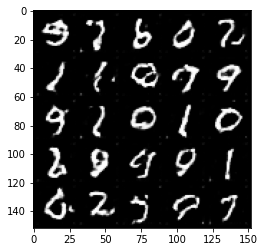

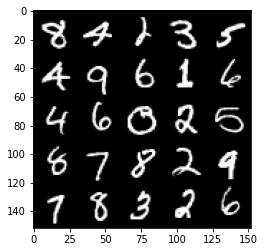

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 0.8261023461818693 Discriminator loss: 0.6063935916423799


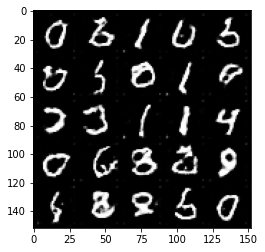

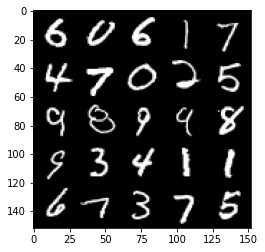

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 0.8289607030153274 Discriminator loss: 0.6050527592897412


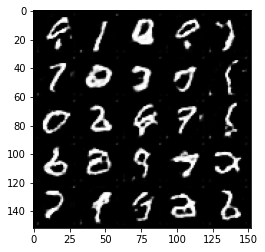

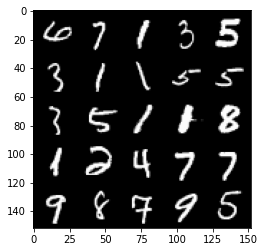

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 0.8291602181196212 Discriminator loss: 0.604844149589538


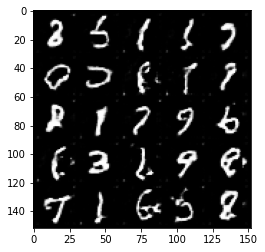

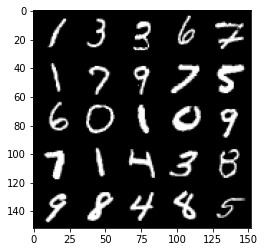

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 0.8297902616262427 Discriminator loss: 0.6044080345630645


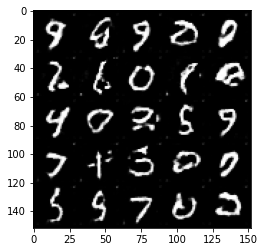

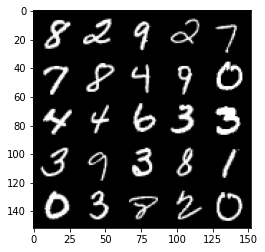

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 0.8308058474659924 Discriminator loss: 0.6020621523857118


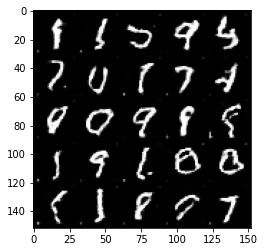

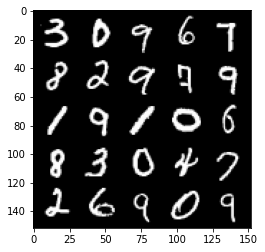

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 0.8315289322733874 Discriminator loss: 0.6039519267082214


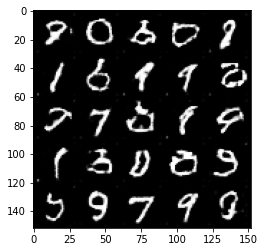

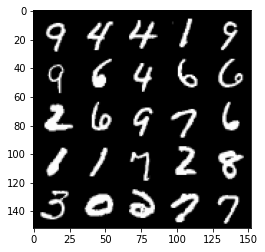

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 0.8365008352994916 Discriminator loss: 0.6026054915189738


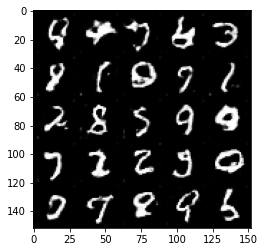

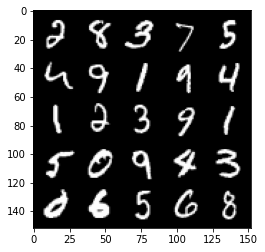

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 0.8327812128067018 Discriminator loss: 0.601601858973503


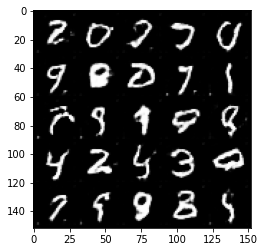

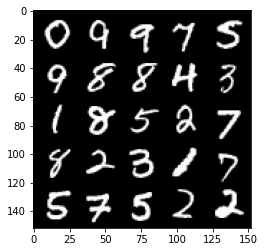

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 0.8377915585041039 Discriminator loss: 0.6000543875694266


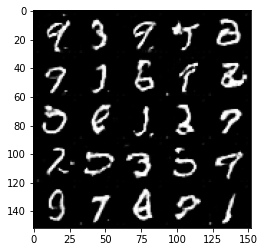

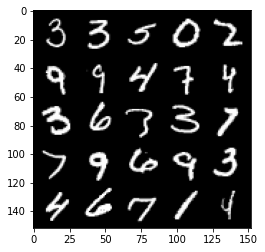

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 0.839634107589721 Discriminator loss: 0.5991499512195587


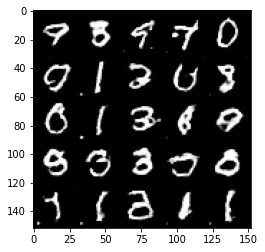

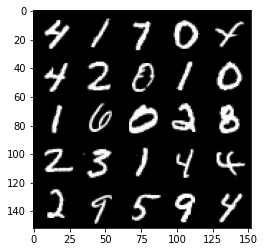

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 0.8427707049846653 Discriminator loss: 0.5990186952352521


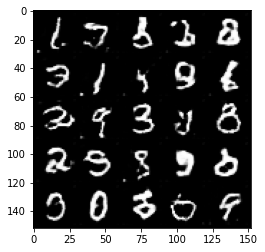

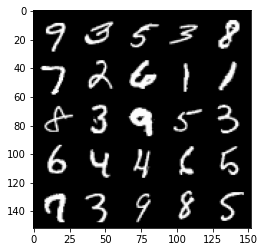

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 0.843751922726631 Discriminator loss: 0.597952131748199


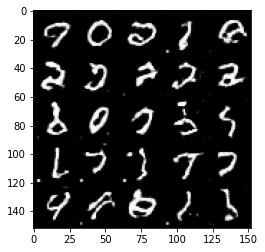

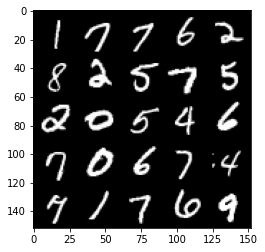

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 0.8466398843526844 Discriminator loss: 0.5985076355934149


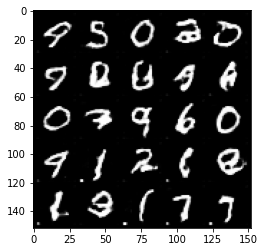

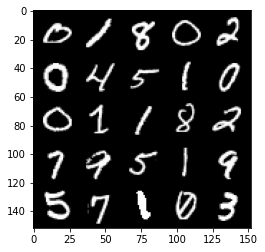

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 0.8445566083192823 Discriminator loss: 0.5975361194610592


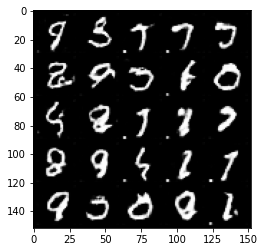

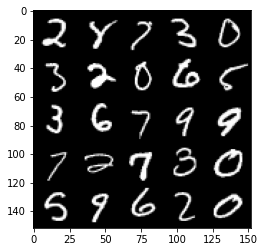

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss: 0.8490104541778555 Discriminator loss: 0.5950894973278043


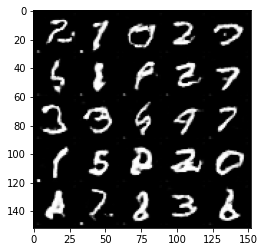

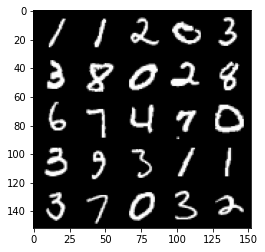

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Generator loss: 0.8481948007941243 Discriminator loss: 0.5952857877016067


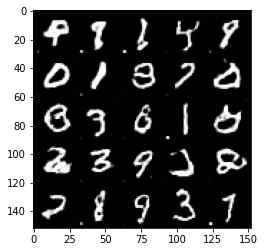

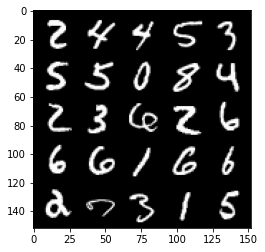

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 0.8511648839712131 Discriminator loss: 0.5941349675655363


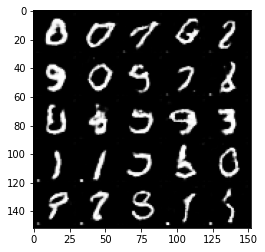

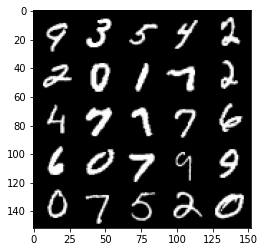

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18500: Generator loss: 0.8546538954973226 Discriminator loss: 0.5941565660238266


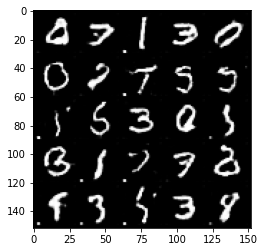

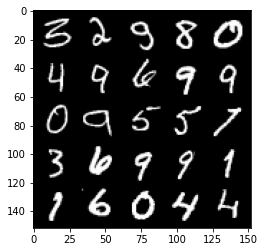

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000: Generator loss: 0.8558036875724799 Discriminator loss: 0.5926567822694778


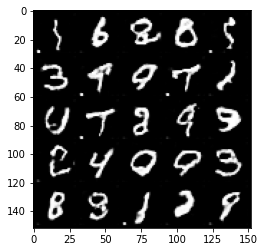

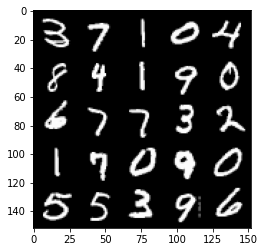

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Generator loss: 0.8555710563659676 Discriminator loss: 0.5916272865533831


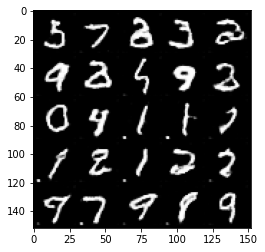

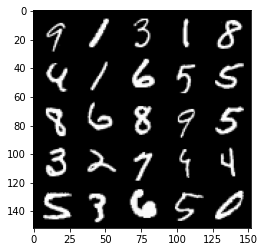

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss: 0.8573680717945102 Discriminator loss: 0.5894430849552151


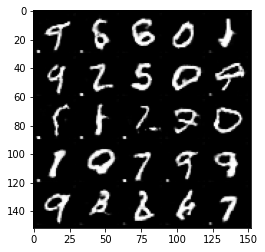

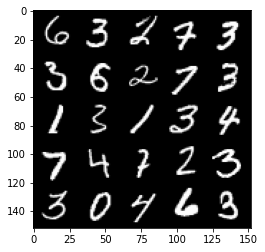

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20500: Generator loss: 0.8623324430584915 Discriminator loss: 0.5882991348505021


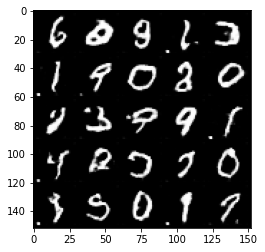

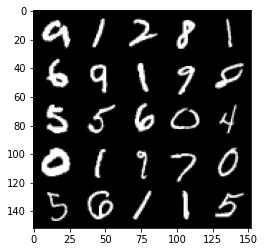

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000: Generator loss: 0.8640078711509701 Discriminator loss: 0.5886661751270297


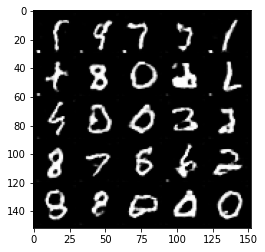

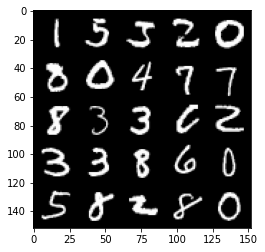

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21500: Generator loss: 0.8636965928673749 Discriminator loss: 0.5888068841695787


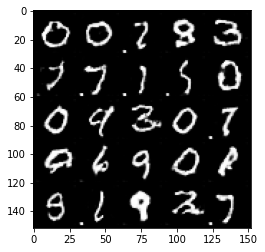

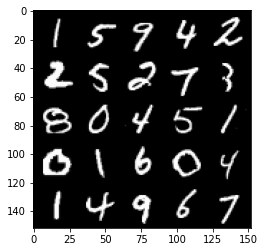

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22000: Generator loss: 0.8684685714244837 Discriminator loss: 0.5873120121955876


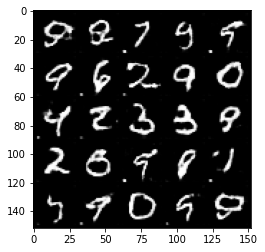

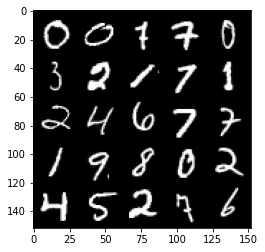

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22500: Generator loss: 0.8673918875455843 Discriminator loss: 0.5854520989656443


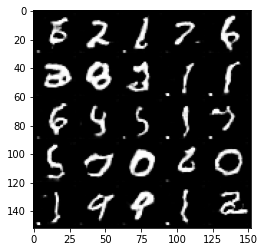

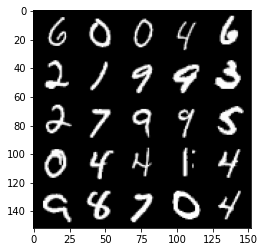

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23000: Generator loss: 0.869611210107803 Discriminator loss: 0.5862951886653898


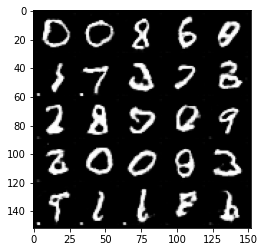

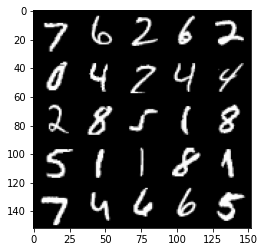

In [25]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
  for real, _ in tqdm(dataloader):
    cur_batch_size = len(real)
    real = real.to(device)
    ## Update Discriminator
    disc_opt.zero_grad()
    fake_noise = get_noise(cur_batch_size, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    # Keep track of the average discriminator loss
    mean_discriminator_loss += disc_loss.item() / display_step
    # Update Gradients
    disc_loss.backward(retain_graph=True)
    # Update Optimizer
    disc_opt.step()

    ## Update Generator
    gen_opt.zero_grad()
    fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
    fake_2 = gen(fake_noise_2)
    disc_fake_pred = disc(fake_2)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    gen_loss.backward()
    gen_opt.step()

    # Keep track of the average generator loss
    mean_generator_loss += gen_loss.item() / display_step

    ## Visualization
    if cur_step % display_step == 0 and cur_step > 0:
      print(f"Step {cur_step}: Generator loss: {mean_generator_loss} Discriminator loss: {mean_discriminator_loss}")
      show_tensor_images(fake)
      show_tensor_images(real)
      mean_generator_loss = 0
      mean_discriminator_loss = 0
    cur_step += 1